In [234]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString
from shapely.ops import unary_union


In [66]:
def calc_timing_offsets():
    timing_offsets = np.zeros((32,12))  # Init matrix
    # constants
    full_firing_cycle = 55.296  # μs
    single_firing = 2.304  # μs
    # compute timing offsets
    for x in range(12):
        for y in range(32):
            dataBlockIndex = (x * 2) + int((y / 16))
            dataPointIndex = y % 16
            timing_offsets[y][x] = (full_firing_cycle * dataBlockIndex) +(single_firing * dataPointIndex)

    return np.array(timing_offsets).T

In [91]:
Data_order = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])
laser_id = np.full((32,12),np.arange(32).reshape(-1,1).astype('int'))
timing_offset = calc_timing_offsets()
omega = Data_order[:,0]
theta = np.sort(omega)
azimuths = np.arange(0,360,0.2)
arg_omega = np.argsort(omega)

def get_pcd_colored(Td_map,Labeling_map,vertical_limits):

    Xs = []
    Ys = []
    Labels = []
    for i in range(vertical_limits[0],vertical_limits[1]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Xs.append(X)
        Ys.append(Y)
        Labels.append(Labeling_map[i])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Labels = np.concatenate(Labels)
    XYZ = np.c_[Xs,Ys]
    Valid_ind = (XYZ[:,0] != 0)&(XYZ[:,1] != 0)
    Labels = Labels[Valid_ind]
    XYZ = XYZ[Valid_ind]

    return XYZ,Labels 

In [90]:
thred_map.shape

(3, 32, 1800)

In [83]:
thred_map = np.load(r'./thred_map.npy')

In [84]:
vertical_limits = [0,31]

In [109]:
bck_points_total = []
for i in range(thred_map.shape[0]):
    Labeling_map = thred_map[i] > 0
    bck_points,Labels = get_pcd_colored(thred_map[i],Labeling_map,vertical_limits)
    bck_points_total.append(bck_points[Labels])
bck_points_total = np.concatenate(bck_points_total)

In [110]:
bck_points_total = np.concatenate(bck_points_total)

In [ ]:
~(np.abs(Td_map - self.thred_map) <= self.bck_radius).any(axis = 0)

In [41]:
def create_buffer_zones_shapely(centerlines, widths):
    lane_polygons = []
    for centerline, width in zip(centerlines, widths):
        line = LineString(centerline)
        # Assuming uniform width for the whole line; divide by 2 for buffer on each side
        buffer_zone = line.buffer(width[0] / 2, resolution=16, cap_style=2, join_style=2)
        lane_polygons.append(buffer_zone)
    return lane_polygons

# Assuming the first width of each lane is the uniform width for simplicity
lane_polygons_shapely = create_buffer_zones_shapely(centerlines, widths)

# To visualize or extract polygon vertices for Pygame
lane_polygons_vertices = [list(poly.exterior.coords) for poly in lane_polygons_shapely]

In [50]:
buffer_zone = lane_polygons_shapely[0]

In [53]:
list(buffer_zone.exterior.coords)

[(150.0, 166.97056274847716),
 (208.48528137423858, 108.48528137423857),
 (191.51471862576142, 91.51471862576143),
 (150.0, 133.02943725152284),
 (108.48528137423857, 91.51471862576143),
 (91.51471862576143, 108.48528137423857),
 (150.0, 166.97056274847716)]

In [44]:
np.array(lane_polygons_vertices[0])

array([[150.        , 166.97056275],
       [208.48528137, 108.48528137],
       [191.51471863,  91.51471863],
       [150.        , 133.02943725],
       [108.48528137,  91.51471863],
       [ 91.51471863, 108.48528137],
       [150.        , 166.97056275]])

In [40]:
# Demo variables
centerlines = [
    [(100, 100), (150, 150), (200, 100)],  # Centerline 1
    [(250, 100), (300, 150), (350, 100)]   # Centerline 2
]
widths = [
    [24, 24],  # Widths for centerline 1 segments
    [12, 12]   # Widths for centerline 2 segments
]

zoom = 1
offset = (0, 0)

In [47]:
res_poly = np.array(lane_polygons_vertices[0])
res_centerline = np.array(centerlines[0])

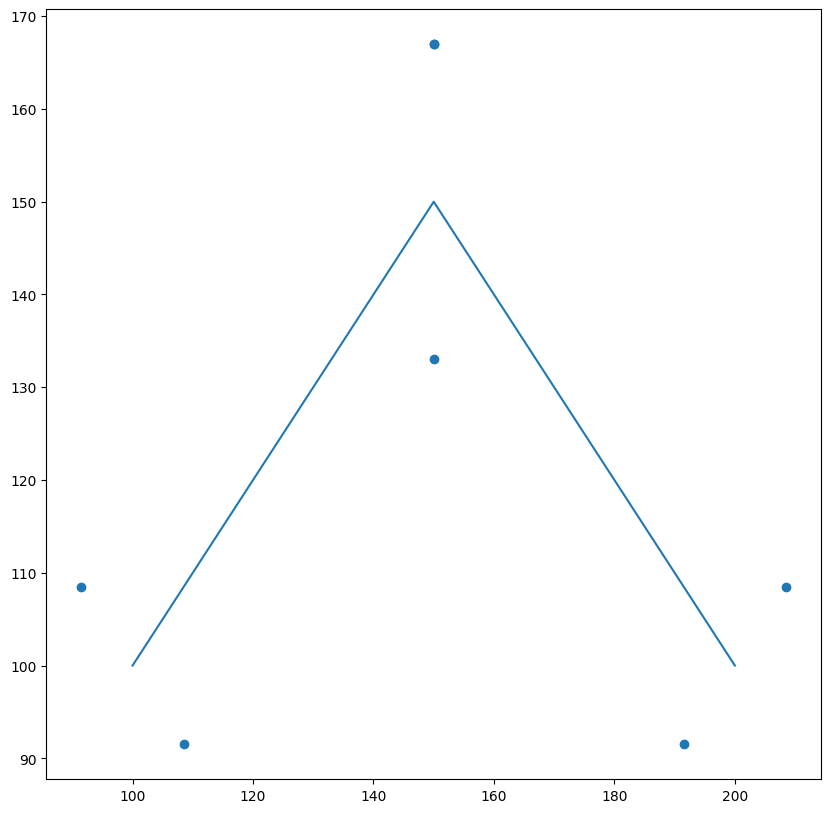

In [48]:
plt.figure(figsize=(10,10))
plt.plot(res_centerline[:,0],res_centerline[:,1])
plt.scatter(res_poly[:,0],res_poly[:,1])

In [118]:
def split_lane_into_subsections(centerline, subsection_length):
    line = LineString(centerline)
    total_length = line.length
    subsections = []
    
    # Generate points along the line at intervals of `subsection_length`
    distances = np.arange(0, total_length, subsection_length)
    points = [line.interpolate(distance) for distance in distances]
    
    # Pair up the points to create subsections. Each subsection is defined by a start and end point
    for i in range(len(points) - 1):
        subsection_start = points[i]
        subsection_end = points[i + 1]
        subsection = LineString([subsection_start, subsection_end])
        subsections.append(subsection)
    
    # Optionally, handle the last segment if there's a remainder
    if distances[-1] < total_length:
        last_point = line.interpolate(total_length)
        last_subsection = LineString([points[-1], last_point])
        subsections.append(last_subsection)
    
    return subsections

In [122]:
# Example centerline for a lane (as a list of (x, y) tuples)
centerline = [(0, 0), (10, 10), (20, 5), (30, 10)]

# Desired subsection length
subsection_length = 2  # Adjust this value based on your needs

# Generate subsections
subsections = split_lane_into_subsections(centerline, subsection_length)

# Print subsections for demonstration
for subsection in subsections:
    print(list(subsection.coords))


[(0.0, 0.0), (1.414213562373095, 1.414213562373095)]
[(1.414213562373095, 1.414213562373095), (2.82842712474619, 2.82842712474619)]
[(2.82842712474619, 2.82842712474619), (4.242640687119285, 4.242640687119285)]
[(4.242640687119285, 4.242640687119285), (5.65685424949238, 5.65685424949238)]
[(5.65685424949238, 5.65685424949238), (7.071067811865475, 7.071067811865475)]
[(7.071067811865475, 7.071067811865475), (8.48528137423857, 8.48528137423857)]
[(8.48528137423857, 8.48528137423857), (9.899494936611665, 9.899494936611665)]
[(9.899494936611665, 9.899494936611665), (11.661724415325136, 9.169137792337432)]
[(11.661724415325136, 9.169137792337432), (13.450578797324969, 8.274710601337516)]
[(13.450578797324969, 8.274710601337516), (15.239433179324799, 7.380283410337601)]
[(15.239433179324799, 7.380283410337601), (17.028287561324632, 6.485856219337684)]
[(17.028287561324632, 6.485856219337684), (18.81714194332446, 5.591429028337769)]
[(18.81714194332446, 5.591429028337769), (20.605996325324295

In [235]:
def calculate_segment_lengths_and_cumulative_lengths(centerline):
    lengths = []
    cumulative_lengths = [0]  # Start with 0 length at the first point
    for i in range(len(centerline) - 1):
        segment = LineString([centerline[i], centerline[i+1]])
        length = segment.length
        lengths.append(length)
        cumulative_lengths.append(cumulative_lengths[-1] + length)
    return lengths, cumulative_lengths
def interpolate_width(cumulative_lengths, widths, position):
    # Find the segment where the position belongs
    for i in range(1, len(cumulative_lengths)):
        if position <= cumulative_lengths[i]:
            segment_start_length = cumulative_lengths[i-1]
            segment_end_length = cumulative_lengths[i]
            segment_relative_position = (position - segment_start_length) / (segment_end_length - segment_start_length)
            
            # Linearly interpolate the width based on the relative position within the segment
            width_at_position = widths[i-1] + (widths[min(i, len(widths)-1)] - widths[i-1]) * segment_relative_position
            return width_at_position
    return widths[-1]  # Return the last width if position is beyond the last segment
from shapely.geometry import LineString

def create_subsection_polygons(centerline, widths, subsection_length):
    lane_line = LineString(centerline)
    total_length = lane_line.length
    subsection_polygons = []
    lengths, cumulative_lengths = calculate_segment_lengths_and_cumulative_lengths(centerline)
    
    distances = np.arange(0, total_length, subsection_length)
    for start_dist in distances:
        end_dist = min(start_dist + subsection_length, total_length)
        
        # Interpolate widths for start and end points of the subsection
        start_width = interpolate_width(cumulative_lengths, widths, start_dist)
        end_width = interpolate_width(cumulative_lengths, widths, end_dist)
        avg_width = (start_width + end_width) / 2  # Use average width for the subsection
        
        start_point = lane_line.interpolate(start_dist)
        end_point = lane_line.interpolate(end_dist)
        subsection_line = LineString([start_point, end_point])
        buffer_polygon = subsection_line.buffer(avg_width / 2, resolution=16, cap_style=2, join_style=2)
        subsection_polygons.append(buffer_polygon)
    
    return unary_union(subsection_polygons)


In [243]:
# centerline = [(0, 0), (10, 10), (20, 5)]  # Example centerline
# widths = [2, 10]  # Example varying widths for each segment
centerline = [(0, 0), (10, 10),(3,5)]  # Example centerline
widths = [2,3]  # Example varying widths for each segment
subsection_length = 2  # Length of each subsection

subsection_polygons = create_subsection_polygons(centerline, widths, subsection_length)


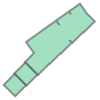

In [246]:
subsection_polygons

In [225]:
temp = []
for poly in subsection_polygons:
    temp += list(poly.exterior.coords)

In [226]:
temp

[(0.5071067811865474, 2.3213203435596426),
 (2.3213203435596426, 0.5071067811865474),
 (0.9071067811865475, -0.9071067811865475),
 (-0.9071067811865475, 0.9071067811865475),
 (0.5071067811865474, 2.3213203435596426),
 (1.521320343559642, 4.135533905932737),
 (4.135533905932737, 1.521320343559642),
 (2.7213203435596425, 0.10710678118654715),
 (0.10710678118654715, 2.7213203435596425),
 (1.521320343559642, 4.135533905932737),
 (2.5355339059327373, 5.949747468305832),
 (5.949747468305832, 2.5355339059327373),
 (4.535533905932738, 1.1213203435596424),
 (1.1213203435596424, 4.535533905932738),
 (2.5355339059327373, 5.949747468305832),
 (3.549747468305832, 7.763961030678928),
 (7.763961030678928, 3.549747468305832),
 (6.349747468305832, 2.135533905932737),
 (2.135533905932737, 6.349747468305832),
 (3.549747468305832, 7.763961030678928),
 (4.563961030678927, 9.578174593052022),
 (9.578174593052022, 4.563961030678927),
 (8.163961030678927, 3.149747468305832),
 (3.149747468305832, 8.16396103067

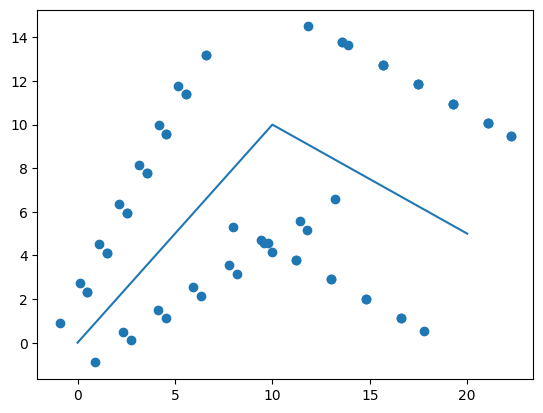

In [228]:
res_centerline = np.array(centerline)
plt.plot(res_centerline[:,0],res_centerline[:,1])
coords = np.array(temp)
plt.scatter(coords[:,0],coords[:,1])